### Portfolio analysis notebook

In [ ]:
# Uncomment the following lines to install the required packages if they are not already installed.
#%pip install seaborn
#%pip install yfinance
#%pip install cvxpy

In [11]:
# 📚 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm

sns.set_theme()

In [12]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', '^GSPC']

# Define portfolio weights (must sum to 1)
# Example: Equal weight to 5 stocks, smaller weight to index
weights = np.array([0.18, 0.18, 0.18, 0.18, 0.18, 0.1])

# Time periods
bull_start, bull_end = '2016-01-01', '2019-12-31'
bear_start, bear_end = '2020-01-01', '2020-06-30'

In [13]:
def get_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Close']
    return data.dropna()

data_bull = get_data(tickers, bull_start, bull_end)
data_bear = get_data(tickers, bear_start, bear_end)

/var/folders/8w/w82r_p153h1dy8ds3tc3lqm00000gn/T/ipykernel_19203/2517156434.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  6 of 6 completed
/var/folders/8w/w82r_p153h1dy8ds3tc3lqm00000gn/T/ipykernel_19203/2517156434.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  6 of 6 completed


In [14]:
returns_bull = data_bull.pct_change().dropna()
returns_bear = data_bear.pct_change().dropna()

In [15]:
def analyze_portfolio(returns, weights, title):
    print(f"\n📊 Portfolio Analysis for {title}")

    # Portfolio returns
    port_ret_daily = returns @ weights
    mean_daily = port_ret_daily.mean()
    vol_daily = port_ret_daily.std()
    
    annual_return = mean_daily * 252
    annual_vol = vol_daily * np.sqrt(252)
    sharpe_ratio = (annual_return - 0.02) / annual_vol

    # Value at Risk
    var_95 = np.percentile(port_ret_daily, 5)
    
    # Conditional VaR (CVaR) or Expected Shortfall
    cvar_95 = port_ret_daily[port_ret_daily <= var_95].mean()

    print(f"\nAnnual Return: {annual_return:.2%}")
    print(f"Annual Volatility: {annual_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"VaR (5%): {var_95:.2%}")
    print(f"CVaR (5%): {cvar_95:.2%}")

    # Correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix - {title}')
    plt.show()

    return {
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe_ratio,
        'VaR 5%': var_95,
        'CVaR 5%': cvar_95,
        'Daily Returns': port_ret_daily
    }


📊 Portfolio Analysis for Bull Market

Annual Return: 25.51%
Annual Volatility: 20.37%
Sharpe Ratio: 1.15
VaR (5%): -2.20%
CVaR (5%): -3.05%


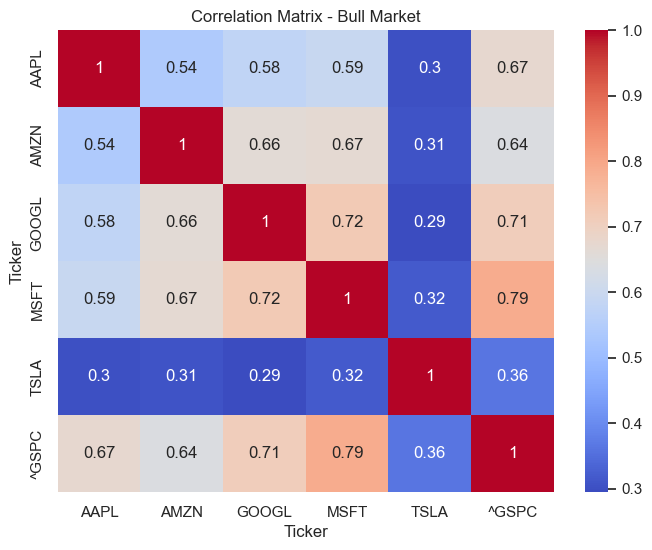


📊 Portfolio Analysis for Bear Market

Annual Return: 77.29%
Annual Volatility: 49.15%
Sharpe Ratio: 1.53
VaR (5%): -4.79%
CVaR (5%): -7.34%


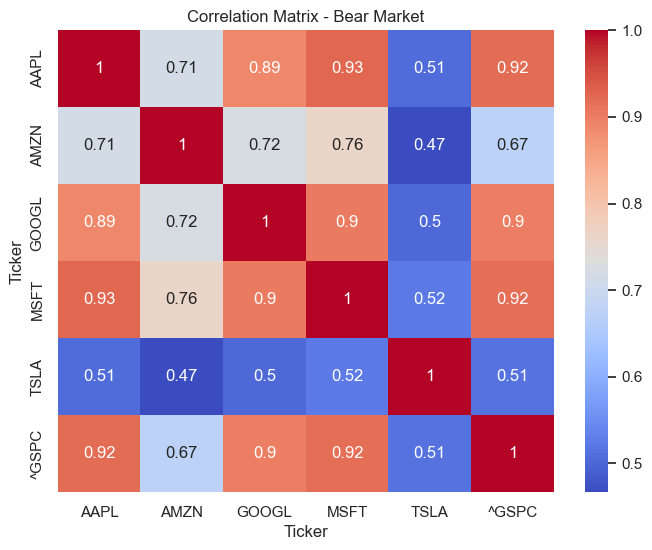

In [16]:
results_bull = analyze_portfolio(returns_bull, weights, "Bull Market")
results_bear = analyze_portfolio(returns_bear, weights, "Bear Market")

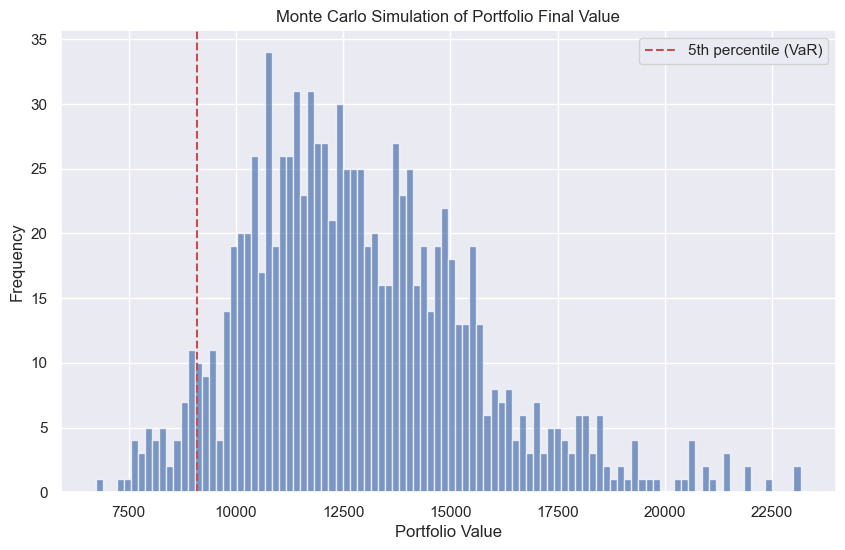

Expected Final Portfolio Value: $12879.01
5% VaR Final Portfolio Value: $9100.16


In [17]:
def monte_carlo_sim(start_val, mu, sigma, days, runs=1000):
    results = np.zeros(runs)
    for i in range(runs):
        daily_returns = np.random.normal(mu / 252, sigma / np.sqrt(252), days)
        price_series = start_val * np.cumprod(1 + daily_returns)
        results[i] = price_series[-1]
    
    plt.figure(figsize=(10, 6))
    plt.hist(results, bins=100, alpha=0.7)
    plt.axvline(np.percentile(results, 5), color='r', linestyle='dashed', label='5th percentile (VaR)')
    plt.title('Monte Carlo Simulation of Portfolio Final Value')
    plt.xlabel('Portfolio Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    print(f"Expected Final Portfolio Value: ${np.mean(results):.2f}")
    print(f"5% VaR Final Portfolio Value: ${np.percentile(results, 5):.2f}")

monte_carlo_sim(10000, results_bull['Annual Return'], results_bull['Annual Volatility'], 252)

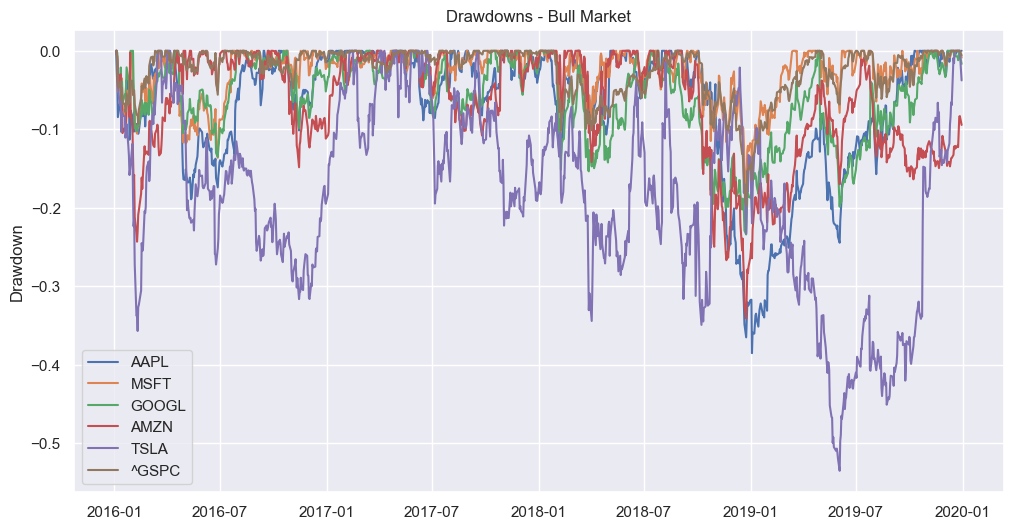

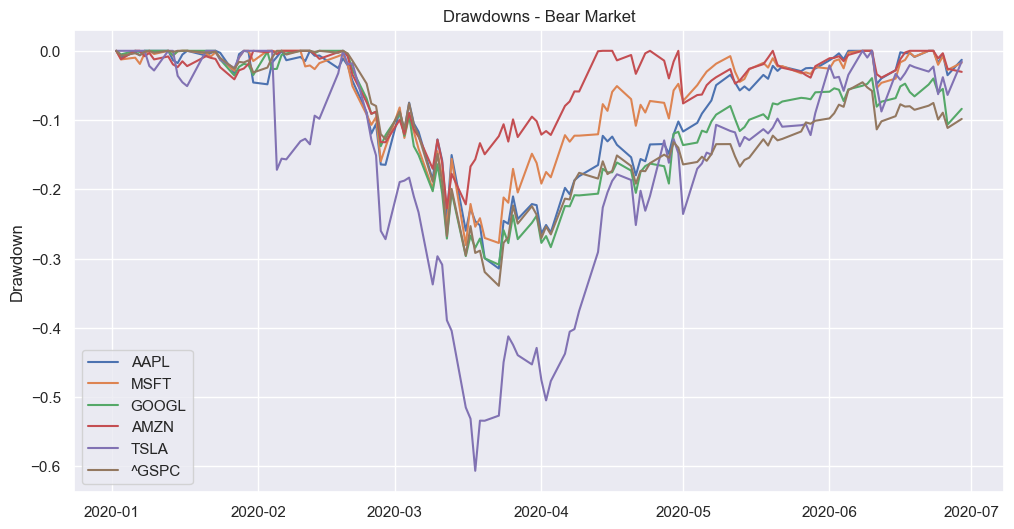

In [18]:
def max_drawdown(price_series):
    cum_max = price_series.cummax()
    drawdown = (price_series - cum_max) / cum_max
    return drawdown

def plot_drawdowns(prices, title):
    plt.figure(figsize=(12, 6))
    for ticker in tickers:
        dd = max_drawdown(prices[ticker])
        plt.plot(dd, label=ticker)
    plt.title(f"Drawdowns - {title}")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.show()

plot_drawdowns(data_bull, "Bull Market")
plot_drawdowns(data_bear, "Bear Market")

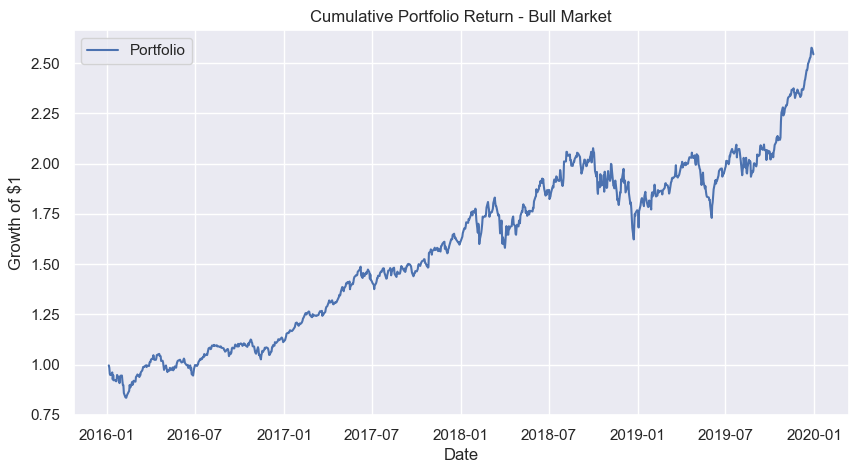

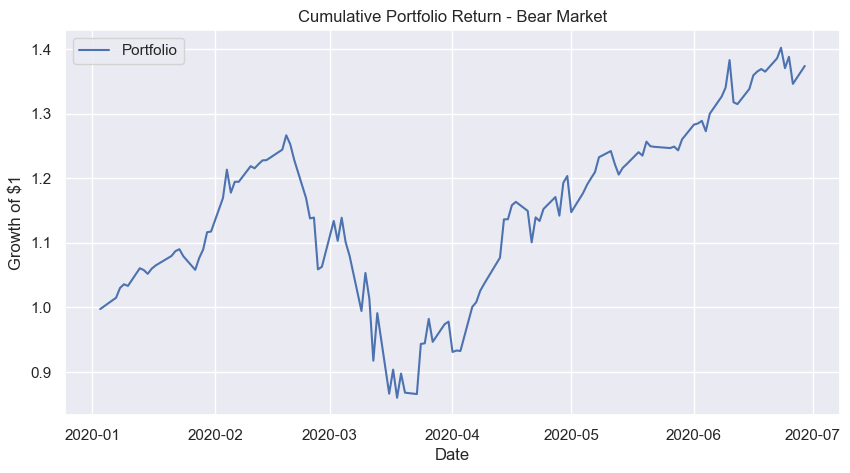

In [19]:
def plot_portfolio_growth(daily_returns, title):
    cumulative = (1 + daily_returns).cumprod()
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative, label='Portfolio')
    plt.title(f'Cumulative Portfolio Return - {title}')
    plt.xlabel('Date')
    plt.ylabel('Growth of $1')
    plt.legend()
    plt.show()

plot_portfolio_growth(results_bull['Daily Returns'], "Bull Market")
plot_portfolio_growth(results_bear['Daily Returns'], "Bear Market")

In [20]:
summary_df = pd.DataFrame({
    'Metric': ['Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'VaR 5%', 'CVaR 5%'],
    'Bull Market': [results_bull['Annual Return'], results_bull['Annual Volatility'],
                    results_bull['Sharpe Ratio'], results_bull['VaR 5%'], results_bull['CVaR 5%']],
    'Bear Market': [results_bear['Annual Return'], results_bear['Annual Volatility'],
                    results_bear['Sharpe Ratio'], results_bear['VaR 5%'], results_bear['CVaR 5%']],
})

print("\n📋 Portfolio Summary:\n")
display(summary_df)

summary_df.to_csv("portfolio_summary_comparison.csv", index=False)


📋 Portfolio Summary:



,Metric,Bull Market,Bear Market
0,Annual Return,0.255132,0.772910
1,Annual Volatility,0.203729,0.491542
2,Sharpe Ratio,1.154139,1.531732
3,VaR 5%,-0.021951,-0.047923
4,CVaR 5%,-0.030484,-0.073411
